In [ ]:
# Install library (jalankan hanya jika belum terinstall)
!pip install -q tensorflow scikit-learn matplotlib seaborn

# Import libreries


In [ ]:
# Import libraries
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Split dataset

In [ ]:
# Set direktori input dan output
original_root = '/content/drive/MyDrive/data_sortir'
output_root = '/content/dataset_flat_split'
split_ratio = [0.8, 0.1, 0.1]  # Train, Val, Test

# Bersihkan direktori output jika sudah ada
if os.path.exists(output_root):
    shutil.rmtree(output_root)
os.makedirs(output_root, exist_ok=True)

splits = ['train', 'val', 'test']

# Flatten dataset berdasarkan penyakit
for plant in os.listdir(original_root):
    plant_path = os.path.join(original_root, plant)
    if not os.path.isdir(plant_path): continue

    for disease in os.listdir(plant_path):
        disease_path = os.path.join(plant_path, disease)
        if not os.path.isdir(disease_path): continue

        images = [f for f in os.listdir(disease_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        np.random.shuffle(images)

        total = len(images)
        train_end = int(total * split_ratio[0])
        val_end = train_end + int(total * split_ratio[1])

        split_files = {
            'train': images[:train_end],
            'val': images[train_end:val_end],
            'test': images[val_end:]
        }

        for split in splits:
            split_dir = os.path.join(output_root, split, disease)
            os.makedirs(split_dir, exist_ok=True)
            for fname in split_files[split]:
                src = os.path.join(disease_path, fname)
                dst = os.path.join(split_dir, f"{plant}_{fname}")  # Rename agar unik
                shutil.copy2(src, dst)

print("✅ Dataset berhasil diflatten dan dibagi berdasarkan penyakit ke dalam train/val/test.")


✅ Dataset berhasil diflatten dan dibagi berdasarkan penyakit ke dalam train/val/test.


In [ ]:
 import os

print("\nStruktur Direktori Dataset Setelah Pembagian:")

for split in splits:
    split_path = os.path.join(output_root, split)
    if os.path.exists(split_path):
        print(f"\n--- {split.upper()} ---")
        diseases = os.listdir(split_path)
        for disease in diseases:
            disease_path = os.path.join(split_path, disease)
            if os.path.isdir(disease_path):
                num_files = len([f for f in os.listdir(disease_path) if os.path.isfile(os.path.join(disease_path, f))])
                print(f"  - {disease}: {num_files} files")
    else:
        print(f"\n--- Direktori {split.upper()} tidak ditemukan. ---")

# Contoh menampilkan beberapa nama file dari subset 'train'
print("\nContoh beberapa nama file di subset 'train':")
train_path = os.path.join(output_root, 'train')
if os.path.exists(train_path):
    diseases = os.listdir(train_path)
    for disease in diseases:
        disease_path = os.path.join(train_path, disease)
        if os.path.isdir(disease_path):
            files = os.listdir(disease_path)
            if files:
                print(f"  - {disease}: {files[:5]}...") # Tampilkan 5 file pertama
            else:
                print(f"  - {disease}: Tidak ada file.")
else:
    print("Subset 'train' tidak ditemukan.")


Struktur Direktori Dataset Setelah Pembagian:

--- TRAIN ---
  - Tomato___Leaf_Mold: 40 files
  - Downy Mildew: 80 files
  - Tomato___healthy: 40 files
  - Yelowwiss: 40 files
  - Tungro: 40 files
  - White Mold Disease: 40 files
  - Black Rot: 40 files
  - DaunSehat: 40 files
  - Tomato___Spider_mites Two-spotted_spider_mite: 40 files
  - Blast: 40 files
  - Tomato___Bacterial_spot: 40 files
  - Cassava___mosaic_disease: 40 files
  - Tomato___Tomato_mosaic_virus: 40 files
  - Fresh Leaf: 40 files
  - Tomato___Septoria_leaf_spot: 40 files
  - Tomato___Late_blight: 40 files
  - Hawar_Daun: 40 files
  - test: 0 files
  - Belly Rot: 40 files
  - Tomato___Early_blight: 40 files
  - Cassava___bacterial_blight: 40 files
  - Bacterial Leaf Spot: 40 files
  - Daun_Sehat: 40 files
  - Virus: 40 files
  - Wilt Disease: 40 files
  - Fresh Cucumber: 40 files
  - Leaf Spot Disease: 40 files
  - Insect Hole: 40 files
  - Tomato___Tomato_Yellow_Leaf_Curl_Virus: 40 files
  - Anthracnose: 40 files
  -

#augmentasi/preprocesing

In [ ]:
# Setup augmentasi dan normalisasi
image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data generator
train_generator = train_datagen.flow_from_directory(
    os.path.join(output_root, 'train'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(output_root, 'val'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(output_root, 'test'),
    target_size=image_size,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


Found 2198 images belonging to 55 classes.
Found 274 images belonging to 55 classes.
Found 276 images belonging to 55 classes.


# Modeling


In [ ]:
# Load VGG16 tanpa top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# Tambahkan fully connected layer
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_vgg16_model.h5', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0303 - loss: 4.4679

69/69 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.0305 - loss: 4.4616 - val_accuracy: 0.0985 - val_loss: 3.4696
Epoch 2/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0914 - loss: 3.5670

69/69 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.0915 - loss: 3.5661 - val_accuracy: 0.2263 - val_loss: 2.9486
Epoch 3/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1051 - loss: 3.3070

69/69 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.1052 - loss: 3.3058 - val_accuracy: 0.2664 - val_loss: 2.6096
Epoch 4/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1327 - loss: 3.0180

69/69 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.1327 - loss: 3.0179 - val_accuracy: 0.3285 - val_loss: 2.3616
Epoch 5/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1607 - loss: 2.8770

69/69 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.1605 - loss: 2.8770 - val_accuracy: 0.3869 - val_loss: 2.1997
Epoch 6/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1794 - loss: 2.7378

69/69 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.1793 - loss: 2.7377 - val_accuracy: 0.3978 - val_loss: 2.0048
Epoch 7/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2067 - loss: 2.5690

69/69 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.2064 - loss: 2.5696 - val_accuracy: 0.3978 - val_loss: 1.9412
Epoch 8/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1934 - loss: 2.5509

69/69 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.1933 - loss: 2.5511 - val_accuracy: 0.3832 - val_loss: 1.8678
Epoch 9/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1989 - loss: 2.5242

69/69 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.1989 - loss: 2.5240 - val_accuracy: 0.4234 - val_loss: 1.7895
Epoch 10/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1795 - loss: 2.5368

69/69 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.1796 - loss: 2.5365 - val_accuracy: 0.4416 - val_loss: 1.6996
Epoch 11/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2068 - loss: 2.4243

69/69 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.2068 - loss: 2.4243 - val_accuracy: 0.4197 - val_loss: 1.6986
Epoch 12/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2106 - loss: 2.3993

69/69 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.2106 - loss: 2.3993 - val_accuracy: 0.4562 - val_loss: 1.6581
Epoch 13/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2364 - loss: 2.3503

69/69 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.2362 - loss: 2.3508 - val_accuracy: 0.4489 - val_loss: 1.6089
Epoch 14/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.2444 - loss: 2.3463 - val_accuracy: 0.4270 - val_loss: 1.6456
Epoch 15/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.2314 - loss: 2.3670 - val_accuracy: 0.4854 - val_loss: 1.6188
Epoch 16/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2340 - loss: 2.3627

69/69 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.2340 - loss: 2.3623 - val_accuracy: 0.5109 - val_loss: 1.5435
Epoch 17/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.2283 - loss: 2.3296 - val_accuracy: 0.4818 - val_loss: 1.6034
Epoch 18/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2039 - loss: 2.2926

69/69 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.2040 - loss: 2.2928 - val_accuracy: 0.4635 - val_loss: 1.5347
Epoch 19/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2318 - loss: 2.3110

69/69 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.2319 - loss: 2.3107 - val_accuracy: 0.5109 - val_loss: 1.5237
Epoch 20/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2619 - loss: 2.3062

69/69 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.2617 - loss: 2.3061 - val_accuracy: 0.5474 - val_loss: 1.5081
Epoch 21/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2493 - loss: 2.2439

69/69 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.2492 - loss: 2.2440 - val_accuracy: 0.5328 - val_loss: 1.4275
Epoch 22/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.2379 - loss: 2.2416 - val_accuracy: 0.5182 - val_loss: 1.5072
Epoch 23/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.2381 - loss: 2.2694 - val_accuracy: 0.4927 - val_loss: 1.4797
Epoch 24/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.2358 - loss: 2.3022 - val_accuracy: 0.5109 - val_loss: 1.4816
Epoch 25/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.2589 - loss: 2.2574 - val_accuracy: 0.5182 - val_loss: 1.4427
Epoch 26/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.2485 - loss: 2.2545 - val_accuracy: 0.5036 - val_loss: 1.4612


#Evaluasi Model


276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step


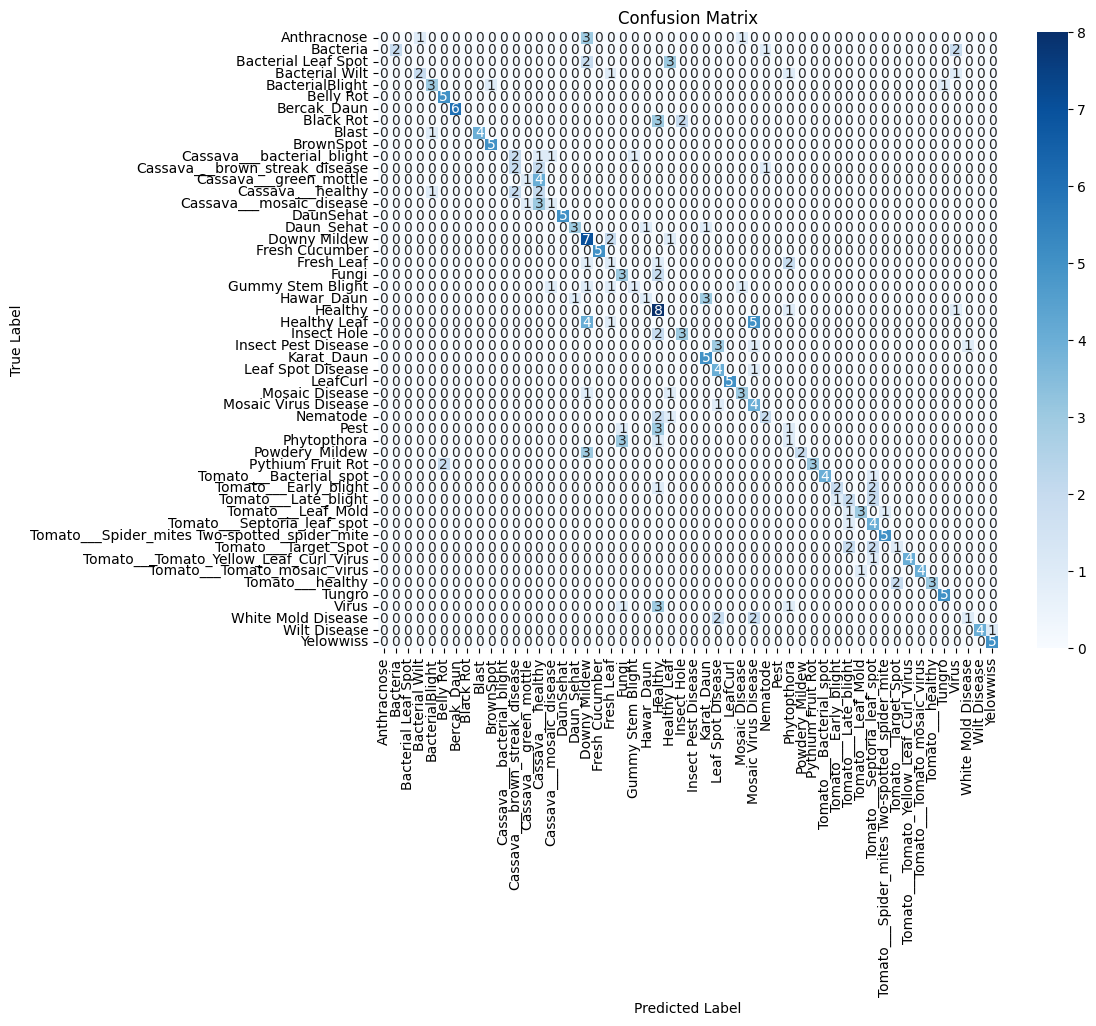

Classification Report:
                                                precision    recall  f1-score   support

                                  Anthracnose       0.00      0.00      0.00         5
                                     Bacteria       1.00      0.40      0.57         5
                          Bacterial Leaf Spot       0.00      0.00      0.00         5
                               Bacterial Wilt       0.67      0.40      0.50         5
                              BacterialBlight       0.60      0.60      0.60         5
                                    Belly Rot       0.71      1.00      0.83         5
                                  Bercak_Daun       1.00      1.00      1.00         6
                                    Black Rot       0.00      0.00      0.00         5
                                        Blast       1.00      0.80      0.89         5
                                    BrownSpot       0.83      1.00      0.91         5
                  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Prediksi pada data test
test_generator.reset()
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Get class labels from the generator's class_indices
# Ensure that class_labels only contains classes present in the test set
all_class_labels = list(test_generator.class_indices.keys())
# Create a mapping from index to class name
idx_to_class = {v: k for k, v in test_generator.class_indices.items()}
# Filter class_labels to only include those present in y_true
class_labels = [idx_to_class[idx] for idx in np.unique(y_true)]


# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true)) # Specify labels for consistency
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

#Visualisasi

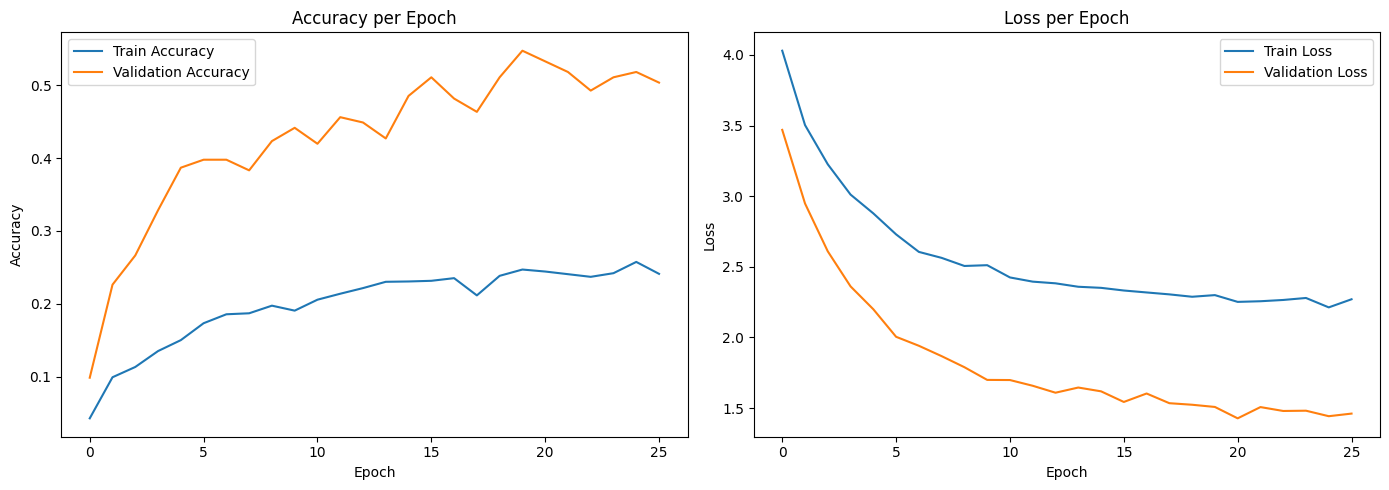

In [ ]:
# Visualisasi Akurasi dan Loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Simpan model
model_save_path = '/content/drive/My Drive/data_sortir/vgg.h5'
model.save(model_save_path)
print(f" Model disimpan ke: {model_save_path}")

 Model disimpan ke: /content/drive/My Drive/data_sortir/vgg.h5


In [ ]:
import pickle

# Ambil label map dari generator
label_map = train_generator.class_indices

# Simpan ke file .pkl
with open('/content/drive/My Drive/data_sortir/label_map.pkl', 'wb') as f:
    pickle.dump(label_map, f)

print("label_map berhasil disimpan.")

label_map berhasil disimpan.
